In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from timm import create_model
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
# Set random seed
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [3]:
# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 15
num_classes = 2
patience = 15  # Early stopping patience

In [4]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformations (no augmentation)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
# Load dataset
train_path = "C:/Users/lamim/Desktop/N_Thesis/split_dataset3/train"
val_path = "C:/Users/lamim/Desktop/N_Thesis/split_dataset3/val"
test_path = "C:/Users/lamim/Desktop/N_Thesis/split_dataset3/test"


In [6]:
# Load training, validation, and test images with transforms
train_data = datasets.ImageFolder(root=train_path, transform=transform)
val_data = datasets.ImageFolder(root=val_path, transform=transform)
test_data = datasets.ImageFolder(root=test_path, transform=transform)

# Create loaders to read the data in batches
# Shuffle training data to mix it up each time
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Don't shuffle validation and test data
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [7]:
# Set the model name (can change this to try other models)
model_name = "deit_small_patch16_224"

# Load a pretrained DeiT-Small model
model = create_model(model_name, pretrained=True)

# Replace the final classification head to match the number of output classes
model.head = nn.Sequential(
    nn.Linear(model.head.in_features, num_classes)
)

# Move model to GPU or CPU
model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Set up Adam optimizer and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Lists to store training and validation metrics
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Track best model for early stopping
best_val_loss = float('inf')
epochs_no_improve = 0

# Training loop
for epoch in range(num_epochs):
    model.train()  # training mode
    running_loss = 0.0
    correct, total = 0, 0
    
    # Go through training batches
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # Apply CutMix augmentation
        lam = np.random.beta(1.0, 1.0)
        rand_index = torch.randperm(images.size(0)).to(device)
        target_a, target_b = labels, labels[rand_index]
        images = lam * images + (1 - lam) * images[rand_index]
        
        # Forward pass and mixed loss
        outputs = model(images)
        loss = lam * criterion(outputs, target_a) + (1 - lam) * criterion(outputs, target_b)
        loss.backward()
        optimizer.step()

        # Track training accuracy and loss
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    # Record training results
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation phase
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    # Record validation results
    val_loss /= len(val_loader)
    val_acc = 100. * correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
    
    # Save best model based on validation loss
    model_path = f'best_model_{model_name}.pth'
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), model_path)
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print('Early stopping!')
            break
    
    # Step the scheduler (may reduce LR after certain epochs)
    scheduler.step()

# Load the best model before testing
model.load_state_dict(torch.load(model_path))
model.eval()
test_loss, correct, total = 0.0, 0, 0

# Test the model
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

# Final test results
test_loss /= len(test_loader)
test_acc = 100. * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

C:\Users\lamim\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\lamim\.cache\huggingface\hub\models--timm--deit_small_patch16_224.fb_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [02:09<00:00,

Epoch 1/15, Loss: 0.6997, Accuracy: 54.5848, Val Loss: 0.6889, Val Accuracy: 54.1071


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [02:09<00:00,  2.12it/s]


Epoch 2/15, Loss: 0.6420, Accuracy: 60.2844, Val Loss: 0.5364, Val Accuracy: 80.7143


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [02:07<00:00,  2.16it/s]


Epoch 3/15, Loss: 0.5754, Accuracy: 67.5654, Val Loss: 0.4560, Val Accuracy: 85.5357


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [02:07<00:00,  2.16it/s]


Epoch 4/15, Loss: 0.5563, Accuracy: 67.8498, Val Loss: 0.4810, Val Accuracy: 80.3571


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [02:09<00:00,  2.13it/s]


Epoch 5/15, Loss: 0.5433, Accuracy: 70.3072, Val Loss: 0.4797, Val Accuracy: 82.8571


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [02:09<00:00,  2.12it/s]


Epoch 6/15, Loss: 0.5144, Accuracy: 70.8419, Val Loss: 0.4206, Val Accuracy: 87.4107


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [02:10<00:00,  2.11it/s]


Epoch 7/15, Loss: 0.5096, Accuracy: 72.2071, Val Loss: 0.5092, Val Accuracy: 80.5357


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [02:08<00:00,  2.13it/s]


Epoch 8/15, Loss: 0.4981, Accuracy: 71.8430, Val Loss: 0.4064, Val Accuracy: 88.2143


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [02:07<00:00,  2.15it/s]


Epoch 9/15, Loss: 0.4985, Accuracy: 71.7292, Val Loss: 0.4318, Val Accuracy: 84.5536


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [02:06<00:00,  2.17it/s]


Epoch 10/15, Loss: 0.4760, Accuracy: 72.8555, Val Loss: 0.4115, Val Accuracy: 88.4821


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [02:10<00:00,  2.11it/s]


Epoch 11/15, Loss: 0.4495, Accuracy: 73.7088, Val Loss: 0.3977, Val Accuracy: 88.2143


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [02:08<00:00,  2.15it/s]


Epoch 12/15, Loss: 0.4577, Accuracy: 74.8919, Val Loss: 0.3832, Val Accuracy: 89.5536


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [02:10<00:00,  2.11it/s]


Epoch 13/15, Loss: 0.4454, Accuracy: 75.6655, Val Loss: 0.3844, Val Accuracy: 89.3750


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [02:08<00:00,  2.15it/s]


Epoch 14/15, Loss: 0.4357, Accuracy: 73.4243, Val Loss: 0.3787, Val Accuracy: 89.8214


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [02:07<00:00,  2.16it/s]


Epoch 15/15, Loss: 0.4210, Accuracy: 76.5301, Val Loss: 0.3729, Val Accuracy: 90.0893


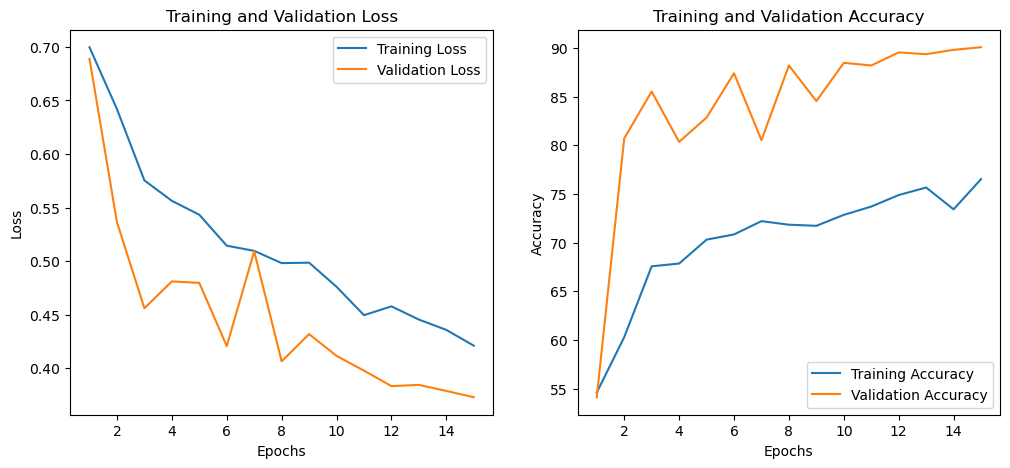

In [8]:
# Plot Training and Validation Loss and Accuracy
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Loss plot
axes[0].plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
axes[0].plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Accuracy plot
axes[1].plot(range(1, len(train_accs)+1), train_accs, label='Training Accuracy')
axes[1].plot(range(1, len(val_accs)+1), val_accs, label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.show()

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [11]:
import matplotlib.pyplot as plt

# Store misclassified and correctly classified images
test_images, test_labels, test_preds = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        # Move images to CPU for visualization
        test_images.extend(images.cpu())  
        test_labels.extend(labels.cpu().numpy())  
        test_preds.extend(predicted.cpu().numpy())  


In [12]:
test_path = "C:/Users/lamim/Desktop/N_Thesis/split_dataset3/test"
test_data = datasets.ImageFolder(root=test_path, transform=transform)
test_loader= DataLoader(test_data, batch_size=batch_size, shuffle=False)
# Load best model for testing
model.load_state_dict(torch.load(model_path))
model.eval()
test_loss, correct, total = 0.0, 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_loss /= len(test_loader)
test_acc = 100. * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Test Loss: 0.4647, Test Accuracy: 85.2174


In [13]:
test_labels, test_preds = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        test_labels.extend(labels.cpu().numpy())  # Store true labels
        test_preds.extend(predicted.cpu().numpy())  # Store predicted labels

# Compute metrics for test set
test_precision = precision_score(test_labels, test_preds, average="macro")
test_recall = recall_score(test_labels, test_preds, average="macro")
test_f1 = f1_score(test_labels, test_preds, average="macro")

print(f"Test Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")


Test Precision: 0.8599, Recall: 0.8634
